# Analyse multivariée qui a pour but de démontrer les profils types des militant.es

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats


import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


from fanalysis.ca import CA 
from fanalysis.mca import MCA
# Importation du fichier csv qui se trouve dans le même dossier que le notebook
data1 = pd.read_csv("CSV/analyse_personnes_occupation.csv")

In [3]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fk_personne      6145 non-null   object
 1   personne         6145 non-null   object
 2   gender           6145 non-null   object
 3   zone_geo         6145 non-null   object
 4   annee_naissance  6145 non-null   int64 
 5   domaines         6145 non-null   object
 6   eff              6145 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 336.2+ KB


In [4]:
data_cop = data1[data1['annee_naissance'] < 2000].copy(deep=True)
data_cop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fk_personne      6145 non-null   object
 1   personne         6145 non-null   object
 2   gender           6145 non-null   object
 3   zone_geo         6145 non-null   object
 4   annee_naissance  6145 non-null   int64 
 5   domaines         6145 non-null   object
 6   eff              6145 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 336.2+ KB


In [5]:
### passer la dataFrame en liste

l = data_cop.values.tolist()

In [6]:
# domaine de militantisme
a = ['acti_climat', 'acti_LGBT', 'acti_femmes', 'acti_humains']

# occupation principale. c'est à dire métier
b = ['enseignement', 'ecrivain_ne','SHS','sciences_experimentales','sante', 'droit']

# autres occupations
c = ['cinema_TV', 'religieux_ses', 'artiste', 'feministe',  'politique', 'autre']

In [7]:
def coder(l, a, b, c):
    
    ll = []

    ## si il n'y a pas d'autres disciplines
    # complète avec disciplines principales additionnelles
   
    d= b + c
    for e in l:

        e = list(e)
        
        o1 = ''
        for el in a:
            # dès que la variable o1 est remplie sort de la boucle
            if el in e[5] and len(o1) == 0:
                o1 = el
                e.append('d1_'+ el)   
        if not(len(o1) > 0):
            e.append('d1_nr')

        o2 = ''
        for el in d:
            if el in e[5] and len(o2) == 0:
                o2 = el
                e.append('d2_'+ o2)
        if not(len(o2) > 0):
            e.append('d2_nr')


        o3 = ''
        for el in b:
            if el in e[5] and len(o3) == 0\
                    and el != o1:
                o3 = el
                e.append('d3_'+ o3)
        if not(len(o3) > 0):
            e.append('d3_nr')

        o4 = ''
        for el in d:
            if len(o4) == 0 and el in e[5]\
                    and el != o3 and el != o1:
                o4 = el
                e.append('d4_'+ o4)
        if not(len(o4) > 0):
            e.append('d4_nr')


        ll.append(e)

    return ll

In [8]:
ll = coder(l, a, b, c)

In [9]:
df_ll = pd.DataFrame(ll, columns=['uri', 'nom', 'genre', 'origine_geo', 'annee_nais',
                      'liste_occup', 'eff_occupations', 'o1', 'o2', 'o3', 'o4'])
df_ll.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              6145 non-null   object
 1   nom              6145 non-null   object
 2   genre            6145 non-null   object
 3   origine_geo      6145 non-null   object
 4   annee_nais       6145 non-null   int64 
 5   liste_occup      6145 non-null   object
 6   eff_occupations  6145 non-null   int64 
 7   o1               6145 non-null   object
 8   o2               6145 non-null   object
 9   o3               6145 non-null   object
 10  o4               6145 non-null   object
dtypes: int64(2), object(9)
memory usage: 528.2+ KB


In [10]:
df_ll.groupby(by='o1').size().sort_values(ascending=False)

o1
d1_acti_humains    2517
d1_acti_femmes     2295
d1_acti_LGBT       1106
d1_acti_climat      227
dtype: int64

In [11]:

df_ll.groupby(by='o4').size().sort_values(ascending=False)


o4
d4_nr                         2646
d4_politique                  1179
d4_autre                       397
d4_cinema_TV                   392
d4_SHS                         365
d4_ecrivain_ne                 334
d4_artiste                     280
d4_feministe                   179
d4_droit                       123
d4_sciences_experimentales      91
d4_religieux_ses                81
d4_sante                        78
dtype: int64

## Commentaire
l'occupation 4 sera abandonnée comme elle n'est pas renseignée pour plus de la moitié de la population

In [12]:
### Année minimale et maximale dans la population
min(df_ll['annee_nais']), max(df_ll['annee_nais'])

(1816, 1999)

In [13]:
l_25 = list(range(1816, 2017, 25))
l_25 [:5], l_25[-5:]

([1816, 1841, 1866, 1891, 1916], [1916, 1941, 1966, 1991, 2016])

In [14]:
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_ll['periodes'] = pd.cut(df_ll['annee_nais'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_ll['periodes'] = df_ll['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_ll.head(3)

,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_femmes,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1891-1915
1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_humains,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1916-1940
2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965


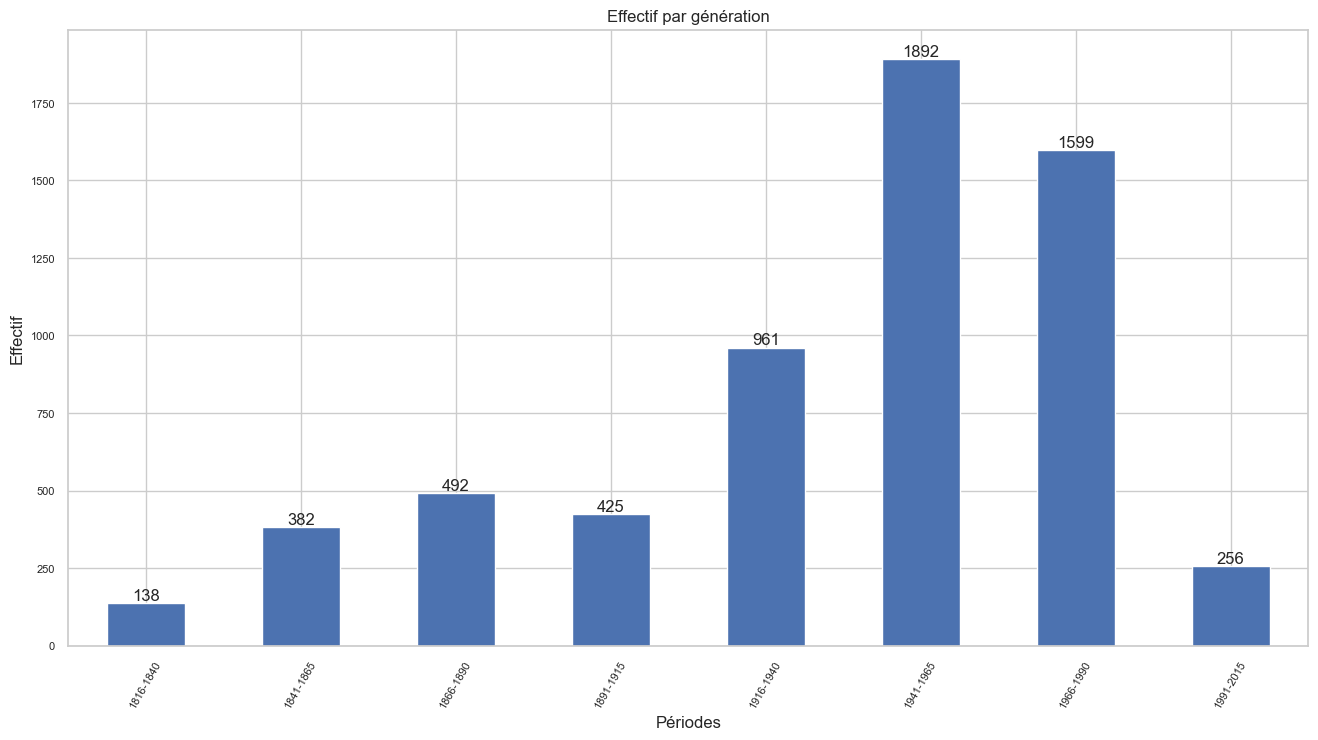

In [125]:
### compter les naissances par périodes de 25 ans
ax = df_ll.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
ax.bar_label(ax.containers[0], fontsize=12)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Effectif par génération')
plt.savefig('images/effectif_25.jpg')
plt.show()

## Profil type pour le XXe siècle
Pour garder de la cohérence nous allons analyser que les personnes qui ont vécu lors du XXe siècle

In [16]:
### On notera l'effectif trop important des individus pour lesquels cette variable
# n'est pas renseignée. Mieux vaudra ne pas l'utiliser
df_d2 = df_ll[df_ll.annee_nais > 1890].groupby(by='o2').size().sort_values(ascending=False)
df_d2

o2
d2_ecrivain_ne                1314
d2_nr                         1237
d2_enseignement                594
d2_politique                   578
d2_droit                       362
d2_SHS                         250
d2_cinema_TV                   200
d2_autre                       188
d2_artiste                     157
d2_sciences_experimentales     107
d2_sante                        85
d2_religieux_ses                51
d2_feministe                    10
dtype: int64

In [17]:
# Exclure les modalités les moins fréquentes
l_d2 = df_d2.index.to_list()[:-2]
print(l_d2)

['d2_ecrivain_ne', 'd2_nr', 'd2_enseignement', 'd2_politique', 'd2_droit', 'd2_SHS', 'd2_cinema_TV', 'd2_autre', 'd2_artiste', 'd2_sciences_experimentales', 'd2_sante']


In [18]:
df_d3 = df_ll[df_ll.annee_nais > 1890].groupby(by='o3').size().sort_values(ascending=False)
df_d3

o3
d3_nr                         2421
d3_ecrivain_ne                1314
d3_enseignement                594
d3_droit                       362
d3_SHS                         250
d3_sciences_experimentales     107
d3_sante                        85
dtype: int64

In [45]:
## j'enlève la santé et quand c'est pas renseigné.
l_d3 = df_d3.index.to_list()[1:6]
print(l_d3)

['d3_ecrivain_ne', 'd3_enseignement', 'd3_droit', 'd3_SHS', 'd3_sciences_experimentales']


In [46]:
df_d4 = df_ll[df_ll.annee_nais > 1890].groupby(by='o4').size().sort_values(ascending=False)
df_d4

o4
d4_nr                         2283
d4_politique                  1024
d4_cinema_TV                   378
d4_autre                       327
d4_SHS                         313
d4_artiste                     240
d4_ecrivain_ne                 226
d4_droit                       108
d4_sciences_experimentales      77
d4_religieux_ses                71
d4_sante                        52
d4_feministe                    34
dtype: int64

In [47]:
df_ll[df_ll.annee_nais > 1890].groupby(by='periodes', observed=True).size().sort_values(ascending=False)

periodes
1941-1965    1892
1966-1990    1599
1916-1940     961
1891-1915     425
1991-2015     256
dtype: int64

In [48]:
cdf_og = df_ll[df_ll.annee_nais > 1890].groupby(by='origine_geo', observed=True).size().sort_values(ascending=False)
cdf_og

origine_geo
Europe              1849
Amérique du nord     982
Asie                 961
Amérique du sud      709
Afrique              507
Océanie              125
dtype: int64

In [49]:
l_og = cdf_og.index.to_list()[:-1]
print(l_og)

['Europe', 'Amérique du nord', 'Asie ', 'Amérique du sud', 'Afrique']


In [50]:
cdf_anne = df_ll.groupby(by='periodes', observed=False).size()
cdf_anne

periodes
1816-1840     138
1841-1865     382
1866-1890     492
1891-1915     425
1916-1940     961
1941-1965    1892
1966-1990    1599
1991-2015     256
dtype: int64

In [51]:
l_annee = cdf_anne.index.to_list()[3:]
print(l_annee)

['1891-1915', '1916-1940', '1941-1965', '1966-1990', '1991-2015']


## Préparer le tableau à analyser

Il est nécessaire de recoder le tableau pour ne pas avoir des variables avec modalités vides: on utilise donc un nouveau tableau avec les individus nés après 1890.

Aussi, si on n'enlève pas les modalités les moins fréquentes (cf. distributions ci-dessus) elles impactent massivement l'analyse factorielle des correspondances multiples, car les modalités les moins fréquentes apportent le plus de variation. On doit donc inspecter manuellement les profils rares mais les exclure de l'ACM pour mettre en évidence des structures plus importantes.

In [52]:
### Créer une copie indépendante du DataFrame 
# tout en éliminant les modalités peu fréquentes 
cdf_mod = df_ll[(df_ll['annee_nais'] > 1890)\
                & (df_ll.origine_geo.isin(l_og))\
                & (df_ll.o2.isin(l_d2))\
                & (df_ll.o3.isin(l_d3))]\
                    .copy(deep=True).reset_index(names='orig_index')
print(len(cdf_mod))
cdf_mod.head(3)

2561


,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
0,0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_femmes,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1891-1915
1,1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_humains,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1916-1940
2,2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965


## Codage de la période
Ce codage permet de mettre de côté le XIXe siècle

In [53]:
### Année minimale et maximale dans la population
min(cdf_mod['annee_nais']), max(cdf_mod['annee_nais'])

(1891, 1999)

In [54]:
## max d'individus
max(cdf_mod.index)

2560

In [55]:
la_25 = list(range(1891, 2017, 25))
la_25[:5],la_25[-5:]

([1891, 1916, 1941, 1966, 1991], [1916, 1941, 1966, 1991, 2016])

In [56]:
cdf_mod['per_25'] = pd.cut(cdf_mod['annee_nais'], la_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_mod['per_25'] = cdf_mod['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_mod.head(3)

,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,per_25
0,0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_femmes,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1891-1915,1891-1915
1,1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_humains,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1916-1940,1916-1940
2,2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965,1941-1965


In [57]:
DActives_ct= cdf_mod[['per_25', 'origine_geo',
 'o1', 'o2', 'o3']].copy(deep=True)

In [58]:
DActives_ct.groupby(by='per_25', observed=False).size()

per_25
1891-1915    220
1916-1940    517
1941-1965    991
1966-1990    744
1991-2015     89
dtype: int64

In [59]:
DActives_ct.groupby(by='origine_geo', observed=True).size().sort_values(ascending=False)

origine_geo
Europe              1073
Amérique du nord     521
Asie                 427
Amérique du sud      309
Afrique              231
dtype: int64

In [60]:
DActives_ct.groupby(by='o1', observed=True).size().sort_values(ascending=False)

o1
d1_acti_humains    1204
d1_acti_femmes      810
d1_acti_LGBT        435
d1_acti_climat      112
dtype: int64

In [61]:
DActives_ct.groupby(by='o2', observed=True).size().sort_values(ascending=False)

o2
d2_ecrivain_ne                1287
d2_enseignement                573
d2_droit                       353
d2_SHS                         244
d2_sciences_experimentales     104
dtype: int64

In [62]:
#Rcupération des infos - nombre de variables
p = DActives_ct.shape[1]
#nombre d'observations
n = DActives_ct.shape[0]
print('Nombre variables:', p, 'Nombre lignes:', n)
#codage en 0/1
X = pd.get_dummies(DActives_ct,prefix='',prefix_sep='')*1

Nombre variables: 5 Nombre lignes: 2561


### Distance des individus par rapport au profil moyen

In [63]:
#Calcul du profil de l'individu moyen
ind_moy = np.sum(X.values,axis=0)/(n*p)
print(ind_moy)

[0.01718079 0.04037485 0.07739164 0.0581023  0.00695041 0.01803983
 0.04068723 0.0241312  0.03334635 0.08379539 0.03397111 0.00874658
 0.06325654 0.09402577 0.01905506 0.02756736 0.10050761 0.04474815
 0.00812183 0.01905506 0.02756736 0.10050761 0.04474815 0.00812183]


In [64]:
### Ajouter une colonne avec la distance chi-2 de chaque individu par rapport à l'individu moyen
# pour chaque individu: les individus plus éloignés sont plus rares
X['dist_org'] = X.apply(lambda x: round(np.sum(1/ind_moy*(x/p-ind_moy)**2),4), raw=True, axis=1)

In [65]:
### Inspecter le tableau
X.sort_values(by='dist_org', ascending=False).head(10)['dist_org']

1560    21.3956
1117    21.3956
1875    19.6556
1994    17.4547
439     17.4547
1319    16.3290
621     15.7693
1804    15.7439
614     15.7439
416     15.5977
Name: dist_org, dtype: float64

count    2561.000000
mean        3.800000
std         2.494427
min         1.215600
25%         2.109300
50%         3.136500
75%         4.618000
max        21.395600
Name: dist_org, dtype: float64


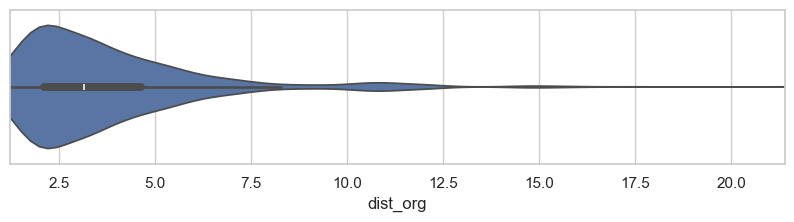

In [66]:
### Distribution de la distance chi-2

sns.set_theme(style="whitegrid",rc={"figure.figsize":(10,2)} )


a = X['dist_org']
# a = X['dist_org'][X['dist_org']< 20]

print(a.describe())

ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(a), right=max(a))

plt.show()

In [67]:
### Ajouter la distance des individus à leur données
# On créé un nouveau DataFrame qui résulte de la jointure des deux précédents
cdf_mod_dist= pd.merge(cdf_mod, X.dist_org, left_index=True, right_index=True)
cdf_mod_dist[:3]

,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,per_25,dist_org
0,0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_femmes,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1891-1915,1891-1915,4.9478
1,1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_humains,d2_enseignement,d3_enseignement,d4_ecrivain_ne,1916-1940,1916-1940,3.1870
2,2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965,1941-1965,1.7213


## Individus proches du profil moyen

In [97]:
## Individus proches du profil moyen
#  donc fréquents
df_filtered = cdf_mod_dist[cdf_mod_dist.dist_org<2]
print(len(df_filtered))
img_moyen = df_filtered.sort_values(by='dist_org')[:5]
img_moyen

564


,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,per_25,dist_org
2556,4921,http://www.wikidata.org/entity/Q100894876,Dana Mazalová,F,Europe,1954,"acti_humains,ecrivain_ne",2,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_nr,1941-1965,1941-1965,1.2156
2205,3981,http://www.wikidata.org/entity/Q4066117,Nikolay Andrushchenko,M,Europe,1943,"acti_humains,ecrivain_ne",2,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_nr,1941-1965,1941-1965,1.2156
343,578,http://www.wikidata.org/entity/Q1662216,Ines Köhler-Zülch,F,Europe,1941,"ecrivain_ne,acti_humains,SHS,SHS,SHS,SHS",6,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_SHS,1941-1965,1941-1965,1.2156
1780,3015,http://www.wikidata.org/entity/Q121818314,Antonio Vermigli,M,Europe,1951,"acti_humains,ecrivain_ne,autre",3,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_autre,1941-1965,1941-1965,1.2156
1757,2971,http://www.wikidata.org/entity/Q125780,Doğan Akhanlı,M,Europe,1957,"ecrivain_ne,acti_humains,ecrivain_ne",3,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_nr,1941-1965,1941-1965,1.2156


In [98]:
D = img_moyen.iloc[0:,3:-2].copy(deep=True)
D

,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
2556,F,Europe,1954,"acti_humains,ecrivain_ne",2,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_nr,1941-1965
2205,M,Europe,1943,"acti_humains,ecrivain_ne",2,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_nr,1941-1965
343,F,Europe,1941,"ecrivain_ne,acti_humains,SHS,SHS,SHS,SHS",6,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_SHS,1941-1965
1780,M,Europe,1951,"acti_humains,ecrivain_ne,autre",3,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_autre,1941-1965
1757,M,Europe,1957,"ecrivain_ne,acti_humains,ecrivain_ne",3,d1_acti_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_nr,1941-1965


In [99]:
print(D.to_markdown())

|      | genre   | origine_geo   |   annee_nais | liste_occup                              |   eff_occupations | o1              | o2             | o3             | o4       | periodes   |
|-----:|:--------|:--------------|-------------:|:-----------------------------------------|------------------:|:----------------|:---------------|:---------------|:---------|:-----------|
| 2556 | F       | Europe        |         1954 | acti_humains,ecrivain_ne                 |                 2 | d1_acti_humains | d2_ecrivain_ne | d3_ecrivain_ne | d4_nr    | 1941-1965  |
| 2205 | M       | Europe        |         1943 | acti_humains,ecrivain_ne                 |                 2 | d1_acti_humains | d2_ecrivain_ne | d3_ecrivain_ne | d4_nr    | 1941-1965  |
|  343 | F       | Europe        |         1941 | ecrivain_ne,acti_humains,SHS,SHS,SHS,SHS |                 6 | d1_acti_humains | d2_ecrivain_ne | d3_ecrivain_ne | d4_SHS   | 1941-1965  |
| 1780 | M       | Europe        |         1951 | acti_

In [100]:
## Inspecter les combinaisons les plus fréquentes
cdf_mod_dist.groupby(by=['per_25','origine_geo','o1','o2','o3'],\
                       observed=True).size().sort_values(ascending=False).head(10)

per_25     origine_geo  o1               o2               o3             
1966-1990  Asie         d1_acti_humains  d2_ecrivain_ne   d3_ecrivain_ne     81
1941-1965  Europe       d1_acti_humains  d2_ecrivain_ne   d3_ecrivain_ne     80
                        d1_acti_LGBT     d2_ecrivain_ne   d3_ecrivain_ne     76
1966-1990  Europe       d1_acti_humains  d2_ecrivain_ne   d3_ecrivain_ne     63
1916-1940  Europe       d1_acti_humains  d2_ecrivain_ne   d3_ecrivain_ne     62
1941-1965  Europe       d1_acti_femmes   d2_ecrivain_ne   d3_ecrivain_ne     57
           Asie         d1_acti_humains  d2_ecrivain_ne   d3_ecrivain_ne     52
1966-1990  Europe       d1_acti_LGBT     d2_ecrivain_ne   d3_ecrivain_ne     48
                        d1_acti_femmes   d2_ecrivain_ne   d3_ecrivain_ne     48
1941-1965  Europe       d1_acti_femmes   d2_enseignement  d3_enseignement    45
dtype: int64

### Individus moyennements distants du profil moyen

In [104]:
### Individus moyennements distants du profil moyen
df_filtered = cdf_mod_dist[(cdf_mod_dist.dist_org>4.3) & (cdf_mod_dist.dist_org <4.9)]
print(len(df_filtered))
img_dist1 = df_filtered.sort_values(by='dist_org')[:5]
img_dist1


170


,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,per_25,dist_org
1245,2082,http://www.wikidata.org/entity/Q6525832,Leonard Weinglass,M,Amérique du nord,1933,"droit,autre,acti_humains",3,d1_acti_humains,d2_droit,d3_droit,d4_autre,1916-1940,1916-1940,4.3012
1726,2910,http://www.wikidata.org/entity/Q15525083,Morris Dees,M,Amérique du nord,1936,"droit,acti_humains,politique",3,d1_acti_humains,d2_droit,d3_droit,d4_politique,1916-1940,1916-1940,4.3012
829,1375,http://www.wikidata.org/entity/Q444106,Patricia Harris,F,Amérique du nord,1924,"droit,politique,politique,acti_humains",4,d1_acti_humains,d2_droit,d3_droit,d4_politique,1916-1940,1916-1940,4.3012
2152,3868,http://www.wikidata.org/entity/Q4766391,Ann Fagan Ginger,F,Amérique du nord,1925,"droit,acti_humains",2,d1_acti_humains,d2_droit,d3_droit,d4_nr,1916-1940,1916-1940,4.3012
739,1197,http://www.wikidata.org/entity/Q6182765,Jerome J. Shestack,M,Amérique du nord,1923,"droit,autre,politique,acti_humains",4,d1_acti_humains,d2_droit,d3_droit,d4_politique,1916-1940,1916-1940,4.3012


In [106]:
K = img_dist1.iloc[0:,3:-2].copy(deep=True)
K

,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
1245,M,Amérique du nord,1933,"droit,autre,acti_humains",3,d1_acti_humains,d2_droit,d3_droit,d4_autre,1916-1940
1726,M,Amérique du nord,1936,"droit,acti_humains,politique",3,d1_acti_humains,d2_droit,d3_droit,d4_politique,1916-1940
829,F,Amérique du nord,1924,"droit,politique,politique,acti_humains",4,d1_acti_humains,d2_droit,d3_droit,d4_politique,1916-1940
2152,F,Amérique du nord,1925,"droit,acti_humains",2,d1_acti_humains,d2_droit,d3_droit,d4_nr,1916-1940
739,M,Amérique du nord,1923,"droit,autre,politique,acti_humains",4,d1_acti_humains,d2_droit,d3_droit,d4_politique,1916-1940


In [107]:
print(K.to_markdown())

|      | genre   | origine_geo      |   annee_nais | liste_occup                            |   eff_occupations | o1              | o2       | o3       | o4           | periodes   |
|-----:|:--------|:-----------------|-------------:|:---------------------------------------|------------------:|:----------------|:---------|:---------|:-------------|:-----------|
| 1245 | M       | Amérique du nord |         1933 | droit,autre,acti_humains               |                 3 | d1_acti_humains | d2_droit | d3_droit | d4_autre     | 1916-1940  |
| 1726 | M       | Amérique du nord |         1936 | droit,acti_humains,politique           |                 3 | d1_acti_humains | d2_droit | d3_droit | d4_politique | 1916-1940  |
|  829 | F       | Amérique du nord |         1924 | droit,politique,politique,acti_humains |                 4 | d1_acti_humains | d2_droit | d3_droit | d4_politique | 1916-1940  |
| 2152 | F       | Amérique du nord |         1925 | droit,acti_humains                   

## Individus très distants du profil moyen

In [108]:
### Individus très distants du profil moyen
#  donc rares, triés en commençant par les plus rares
df_filtered = cdf_mod_dist[cdf_mod_dist.dist_org>15]
print(len(df_filtered))
img_distant2 = df_filtered.sort_values(by='dist_org', ascending=False)[:7]


13


In [109]:
R = img_distant2.iloc[0:,3:-2].copy(deep=True)
R

,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
1117,M,Afrique,1996,"acti_humains,acti_climat,sciences_experimental...",4,d1_acti_climat,d2_sciences_experimentales,d3_sciences_experimentales,d4_politique,1991-2015
1560,F,Afrique,1997,"sciences_experimentales,autre,acti_climat",3,d1_acti_climat,d2_sciences_experimentales,d3_sciences_experimentales,d4_autre,1991-2015
1875,F,Europe,1994,"sciences_experimentales,acti_climat,acti_climat",3,d1_acti_climat,d2_sciences_experimentales,d3_sciences_experimentales,d4_nr,1991-2015
439,F,Afrique,1994,"artiste,artiste,sciences_experimentales,artist...",5,d1_acti_femmes,d2_sciences_experimentales,d3_sciences_experimentales,d4_artiste,1991-2015
1994,F,Afrique,1992,"sciences_experimentales,acti_femmes",2,d1_acti_femmes,d2_sciences_experimentales,d3_sciences_experimentales,d4_nr,1991-2015
1319,F,Afrique,1984,"sciences_experimentales,acti_humains,acti_climat",3,d1_acti_climat,d2_sciences_experimentales,d3_sciences_experimentales,d4_nr,1966-1990
621,M,Amérique du sud,1980,"autre,acti_humains,acti_climat,sciences_experi...",5,d1_acti_climat,d2_sciences_experimentales,d3_sciences_experimentales,d4_autre,1966-1990


In [110]:
print(K.to_markdown())

|      | genre   | origine_geo      |   annee_nais | liste_occup                            |   eff_occupations | o1              | o2       | o3       | o4           | periodes   |
|-----:|:--------|:-----------------|-------------:|:---------------------------------------|------------------:|:----------------|:---------|:---------|:-------------|:-----------|
| 1245 | M       | Amérique du nord |         1933 | droit,autre,acti_humains               |                 3 | d1_acti_humains | d2_droit | d3_droit | d4_autre     | 1916-1940  |
| 1726 | M       | Amérique du nord |         1936 | droit,acti_humains,politique           |                 3 | d1_acti_humains | d2_droit | d3_droit | d4_politique | 1916-1940  |
|  829 | F       | Amérique du nord |         1924 | droit,politique,politique,acti_humains |                 4 | d1_acti_humains | d2_droit | d3_droit | d4_politique | 1916-1940  |
| 2152 | F       | Amérique du nord |         1925 | droit,acti_humains                   

## Inspection des modalités des variables

C'est à ce stade qu'on vérifie le poids des modalités rares et qu'on décide éventuellement d'en enlever encore davantage, afin d'éviter qu'elle cachent la structure du champ scientifique.

Quant aux individus possédant ces modalités rares, on pourra les étudier séparément.

Rappelons que l'ACM appartient au domaine des statistiques descriptives et que pour la recherche en sciences historiques celles-ci ont une fonction heuristique, non explicative. Elles permettent toutefois de mettre en évidence des phénomènes invisibles autrement.



In [111]:
### Profil moyen colonnes
moda_moy = np.ones(X.shape[0])/n
moda_moy[:10]

array([0.00039047, 0.00039047, 0.00039047, 0.00039047, 0.00039047,
       0.00039047, 0.00039047, 0.00039047, 0.00039047, 0.00039047])

In [112]:
# enelver la colonne 'dist-org'
df = X.iloc[:,:-1]
# somme en colonne
somme_col = np.sum(df.values,axis=0)
print(somme_col)
# poids des variables_modalités (points modalités)
poids_moda = somme_col/(n*p)
# distance au chi-2 de la valeur moyenne
disto_moda = np.apply_along_axis(arr=df.values/somme_col,axis=0,func1d=lambda x:
np.sum(n*(x-moda_moy)**2))
#np
inertie_moda = poids_moda * disto_moda
#affichage
dfc = pd.DataFrame(np.transpose([poids_moda,disto_moda,inertie_moda]),index=df.columns,columns=['Poids','Disto','Inertie'])


### La disposition des lignes est en fonction des modalités, 
# et la somme des colonnes a été transposée pour avoir des lignes
dfc

[ 220  517  991  744   89  231  521  309  427 1073  435  112  810 1204
  244  353 1287  573  104  244  353 1287  573  104]


,Poids,Disto,Inertie
1891-1915,0.017181,10.640909,0.182819
1916-1940,0.040375,3.953578,0.159625
1941-1965,0.077392,1.584258,0.122608
1966-1990,0.058102,2.442204,0.141898
1991-2015,0.006950,27.775281,0.193050
Afrique,0.018040,10.086580,0.181960
Amérique du nord,0.040687,3.915547,0.159313
Amérique du sud,0.024131,7.288026,0.175869
Asie,0.033346,4.997658,0.166654
Europe,0.083795,1.386766,0.116205


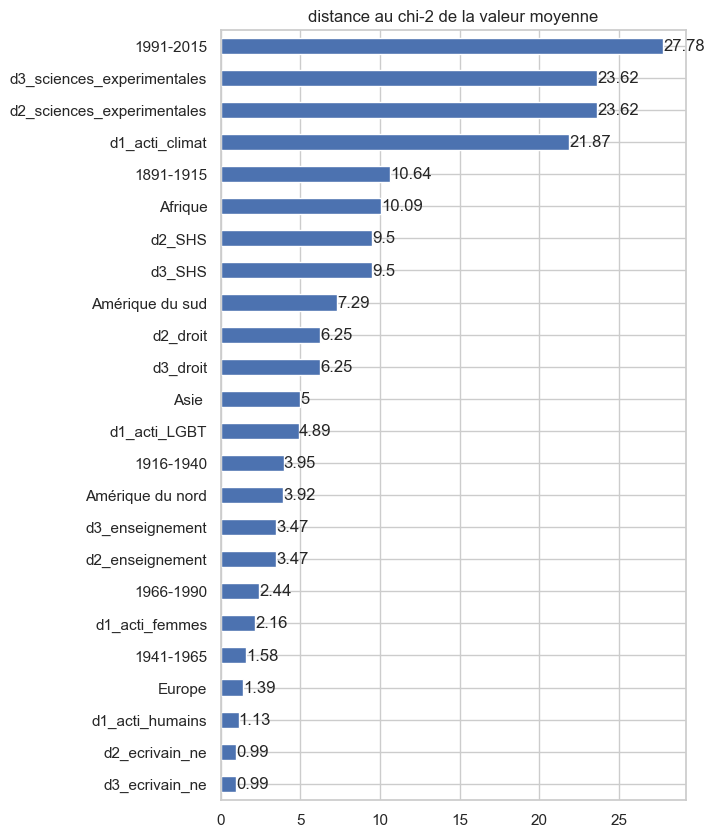

In [114]:
### distance au chi-2 de la valeur moyenne
# Les premières modalités sont celles qui sont plus rares
ax = round(dfc.Disto.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(6,10))

ax.bar_label(ax.containers[0])
ax.set_title('distance au chi-2 de la valeur moyenne')
plt.savefig('images/modalite_rare.jpg', bbox_inches='tight')
plt.show()

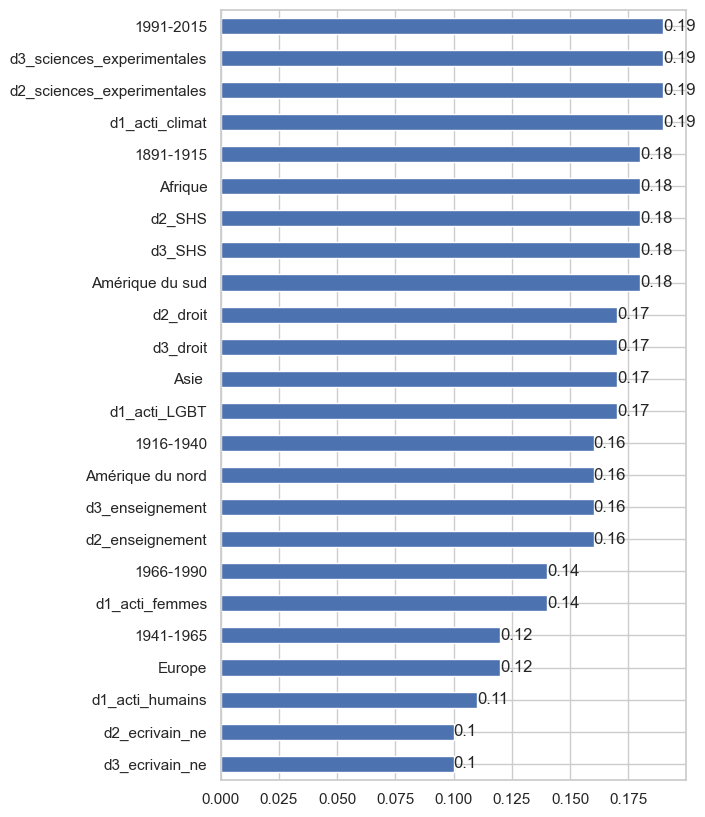

In [115]:
### Inertie, i.e. contribution à la variance
ax = round(dfc.Inertie.sort_values(ascending=True),2).plot(kind='barh', 
                    figsize=(6,10))

ax.bar_label(ax.containers[0])

plt.show()

## Représentation graphique

In [116]:
acm = MCA(row_labels=DActives_ct.index,var_labels=DActives_ct.columns)
acm.fit(DActives_ct.values)

MCA(row_labels=RangeIndex(start=0, stop=2561, step=1),
    var_labels=Index(['per_25', 'origine_geo', 'o1', 'o2', 'o3'], dtype='object'))

In [117]:
eig = pd.DataFrame(acm.eig_).transpose()
eig.columns=['contribution','freq','freq_cumulee']

eig.head(), eig.tail()

(   contribution       freq  freq_cumulee
 0      0.442106  11.634375     11.634375
 1      0.416028  10.948110     22.582485
 2      0.409106  10.765956     33.348441
 3      0.404505  10.644866     43.993307
 4      0.244855   6.443559     50.436866,
     contribution          freq  freq_cumulee
 14  1.202532e-01  3.164558e+00         100.0
 15  4.440059e-31  1.168437e-29         100.0
 16  1.589678e-31  4.183363e-30         100.0
 17  1.009492e-31  2.656558e-30         100.0
 18  9.468117e-32  2.491610e-30         100.0)

In [118]:
### Nombre total de modalités, toute variable confondue
M = X.shape[1]
print('Nombre de modalités:', M)
#nombre max de facteurs
Hmax = M-p
print('Nombre maximal de facteurs:', Hmax)

Nombre de modalités: 25
Nombre maximal de facteurs: 20


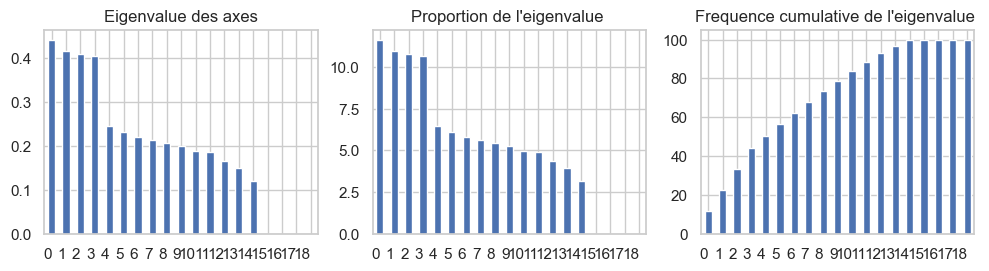

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

eig.iloc[:,0].plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
eig.iloc[:,1].plot(kind='bar', ax=axes[1], title="Proportion de l'eigenvalue ")
eig.iloc[:,2].plot(kind='bar', ax=axes[2], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

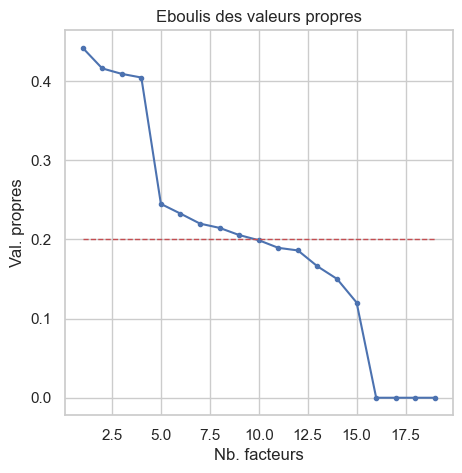

In [120]:
#éboulis des v.p.

xvalues = len(acm.eig_[0])+1

fix,ax = plt.subplots(figsize=(5,5))
ax.plot(range(1,xvalues),acm.eig_[0],".-")
ax.set_xlabel("Nb. facteurs")
ax.set_ylabel("Val. propres")
plt.title("Eboulis des valeurs propres")
#seuil - Règle de Kaiser
ax.plot([1,xvalues-1],[1/p,1/p],"r--",linewidth=1)
plt.show()

In [121]:
### Correction de Benzecri, cf. Rakotomalala, Pratique, p.313sqq

#somme en colonne
#récupérer les valeurs propres supérieur à (1/p)
lambada = acm.eig_[0][acm.eig_[0]>1/p]
#print(lambada)

#appliquer la correction
lambada_prim = ((p/(p-1))*(lambada-1/p))**2
#print(lambada_prim)

#faire la somme
S_prim = np.sum(lambada_prim)
#print('u',S_prim)

#et produire les pourcentages
percent_prim = lambada_prim/S_prim*100

#affichage
bzc = pd.DataFrame(np.transpose(np.array([lambada_prim,percent_prim,
                                np.cumsum(percent_prim)])),columns=['Val.P','freq','Cumul_freq'],
                                index=range(1,len(percent_prim)+1))
print(bzc)

      Val.P       freq  Cumul_freq
1  0.091587  30.129370   30.129370
2  0.072919  23.988269   54.117638
3  0.068321  22.475656   76.593294
4  0.065347  21.497383   98.090678
5  0.003144   1.034200   99.124877
6  0.001660   0.546167   99.671045
7  0.000621   0.204440   99.875485
8  0.000331   0.108895   99.984380
9  0.000047   0.015620  100.000000


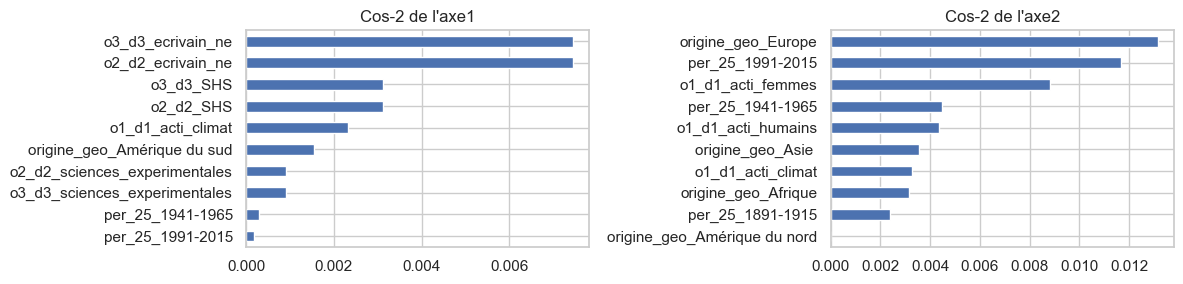

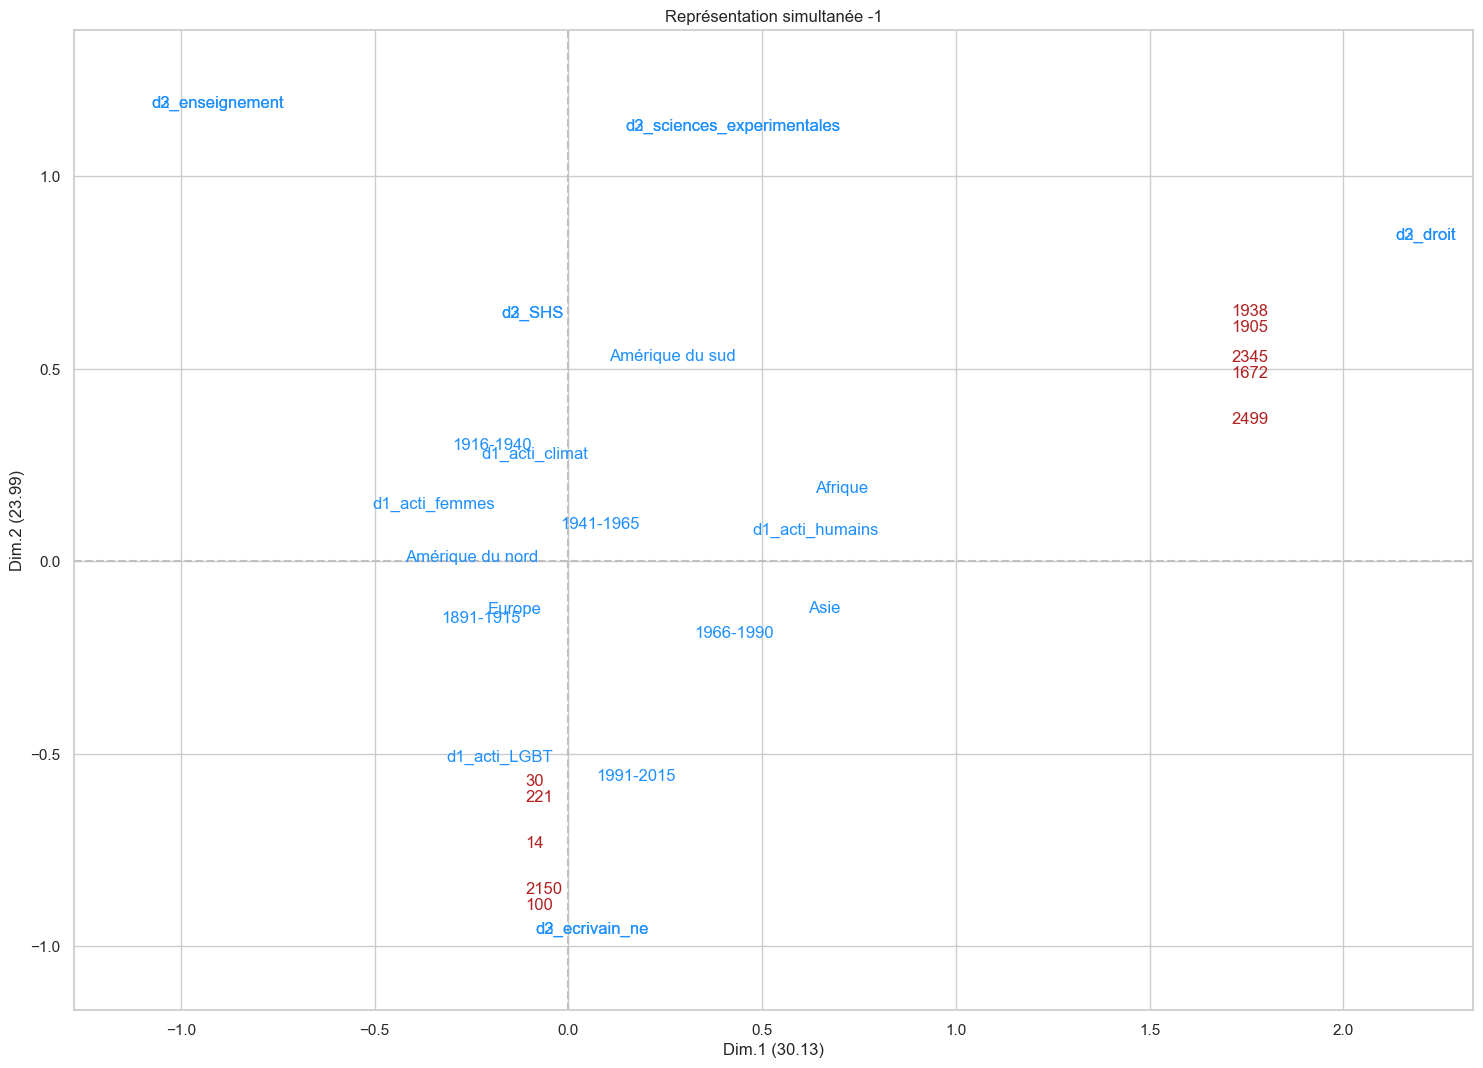

|      | per_25    | origine_geo   | o1              | o2             | o3             |
|-----:|:----------|:--------------|:----------------|:---------------|:---------------|
| 2499 | 1966-1990 | Asie          | d1_acti_humains | d2_droit       | d3_droit       |
|  100 | 1966-1990 | Europe        | d1_acti_LGBT    | d2_ecrivain_ne | d3_ecrivain_ne |
| 2150 | 1966-1990 | Europe        | d1_acti_LGBT    | d2_ecrivain_ne | d3_ecrivain_ne |
| 1672 | 1966-1990 | Asie          | d1_acti_humains | d2_droit       | d3_droit       |
| 2345 | 1966-1990 | Asie          | d1_acti_humains | d2_droit       | d3_droit       |
|   14 | 1966-1990 | Europe        | d1_acti_LGBT    | d2_ecrivain_ne | d3_ecrivain_ne |
| 1905 | 1966-1990 | Asie          | d1_acti_humains | d2_droit       | d3_droit       |
| 1938 | 1966-1990 | Asie          | d1_acti_humains | d2_droit       | d3_droit       |
|  221 | 1966-1990 | Europe        | d1_acti_LGBT    | d2_ecrivain_ne | d3_ecrivain_ne |
|   30 | 1966-1990 | 

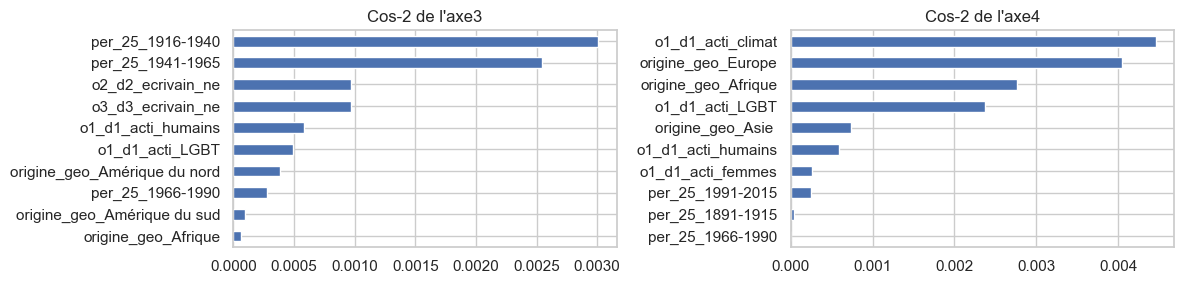

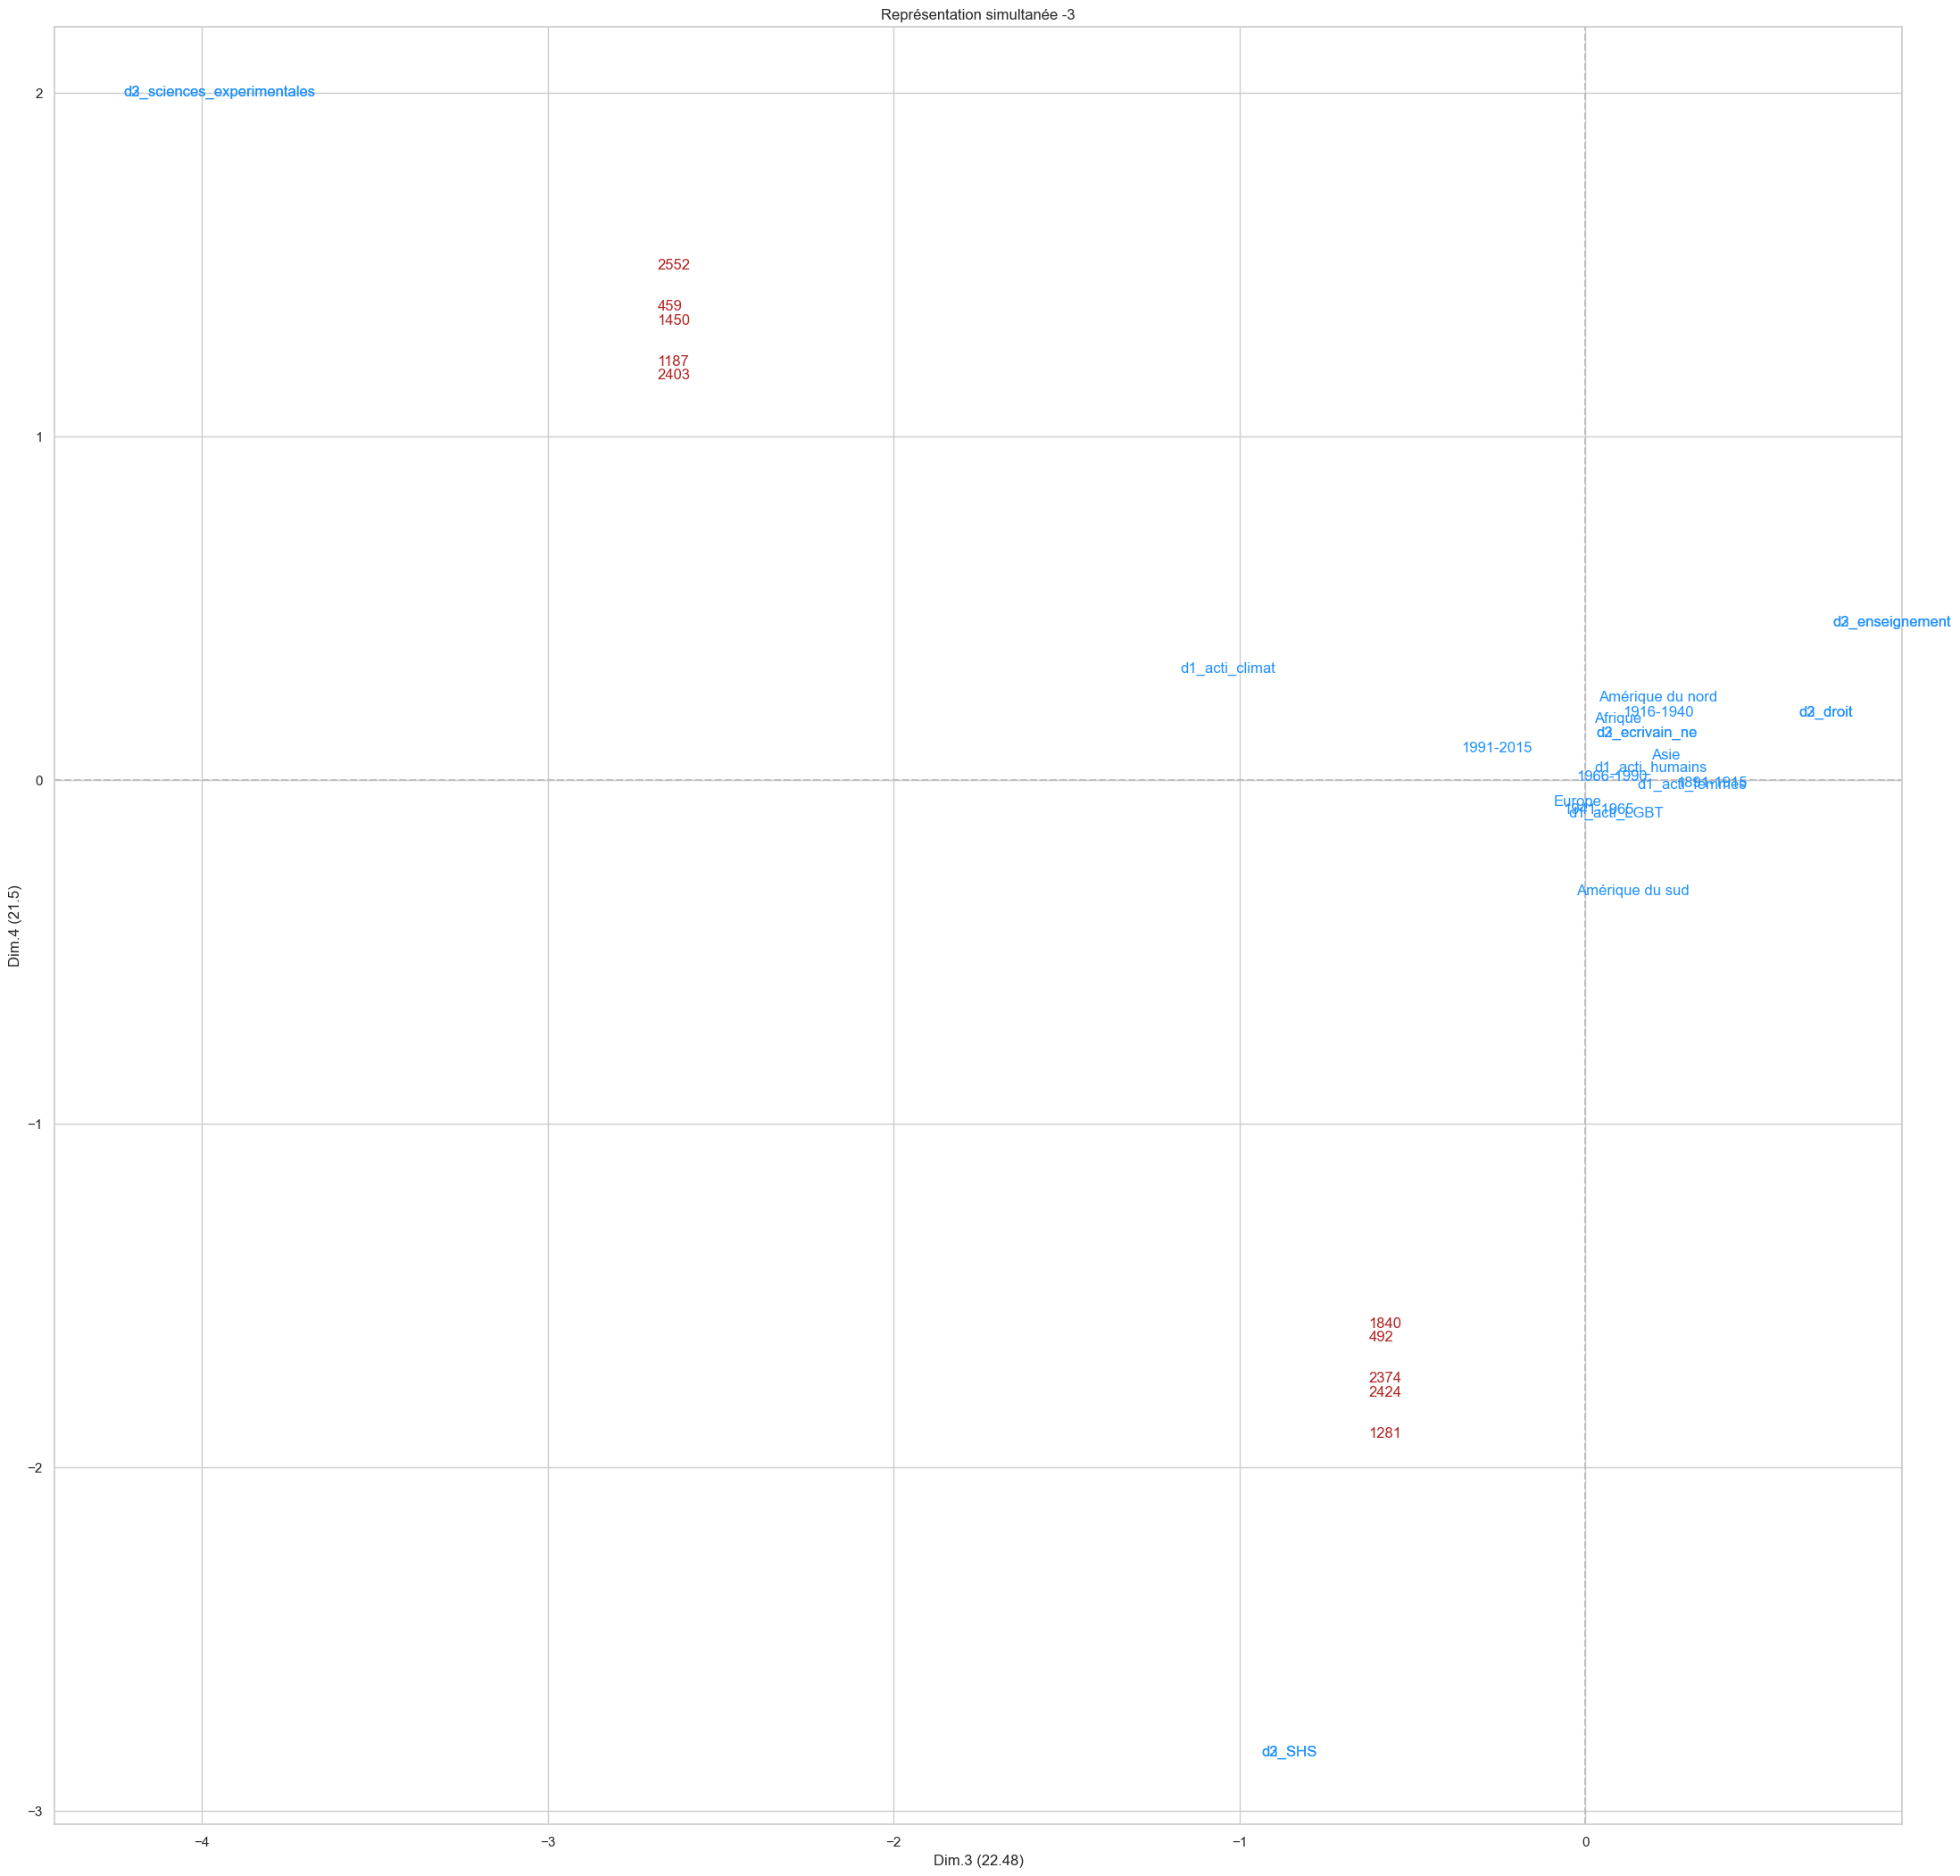

|      | per_25    | origine_geo   | o1              | o2                         | o3                         |
|-----:|:----------|:--------------|:----------------|:---------------------------|:---------------------------|
| 1281 | 1941-1965 | Europe        | d1_acti_humains | d2_SHS                     | d3_SHS                     |
| 2403 | 1941-1965 | Europe        | d1_acti_humains | d2_sciences_experimentales | d3_sciences_experimentales |
| 1187 | 1941-1965 | Europe        | d1_acti_humains | d2_sciences_experimentales | d3_sciences_experimentales |
| 2424 | 1941-1965 | Europe        | d1_acti_humains | d2_SHS                     | d3_SHS                     |
| 2374 | 1941-1965 | Europe        | d1_acti_humains | d2_SHS                     | d3_SHS                     |
| 1450 | 1941-1965 | Europe        | d1_acti_humains | d2_sciences_experimentales | d3_sciences_experimentales |
|  459 | 1941-1965 | Europe        | d1_acti_humains | d2_sciences_experimentales | d3_sciences_

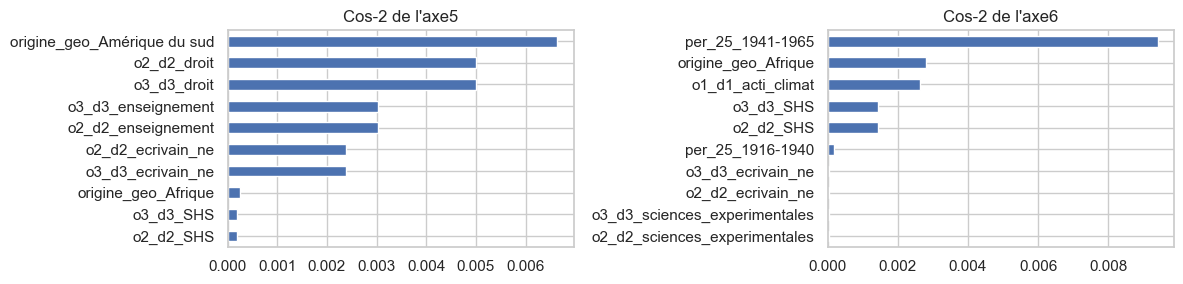

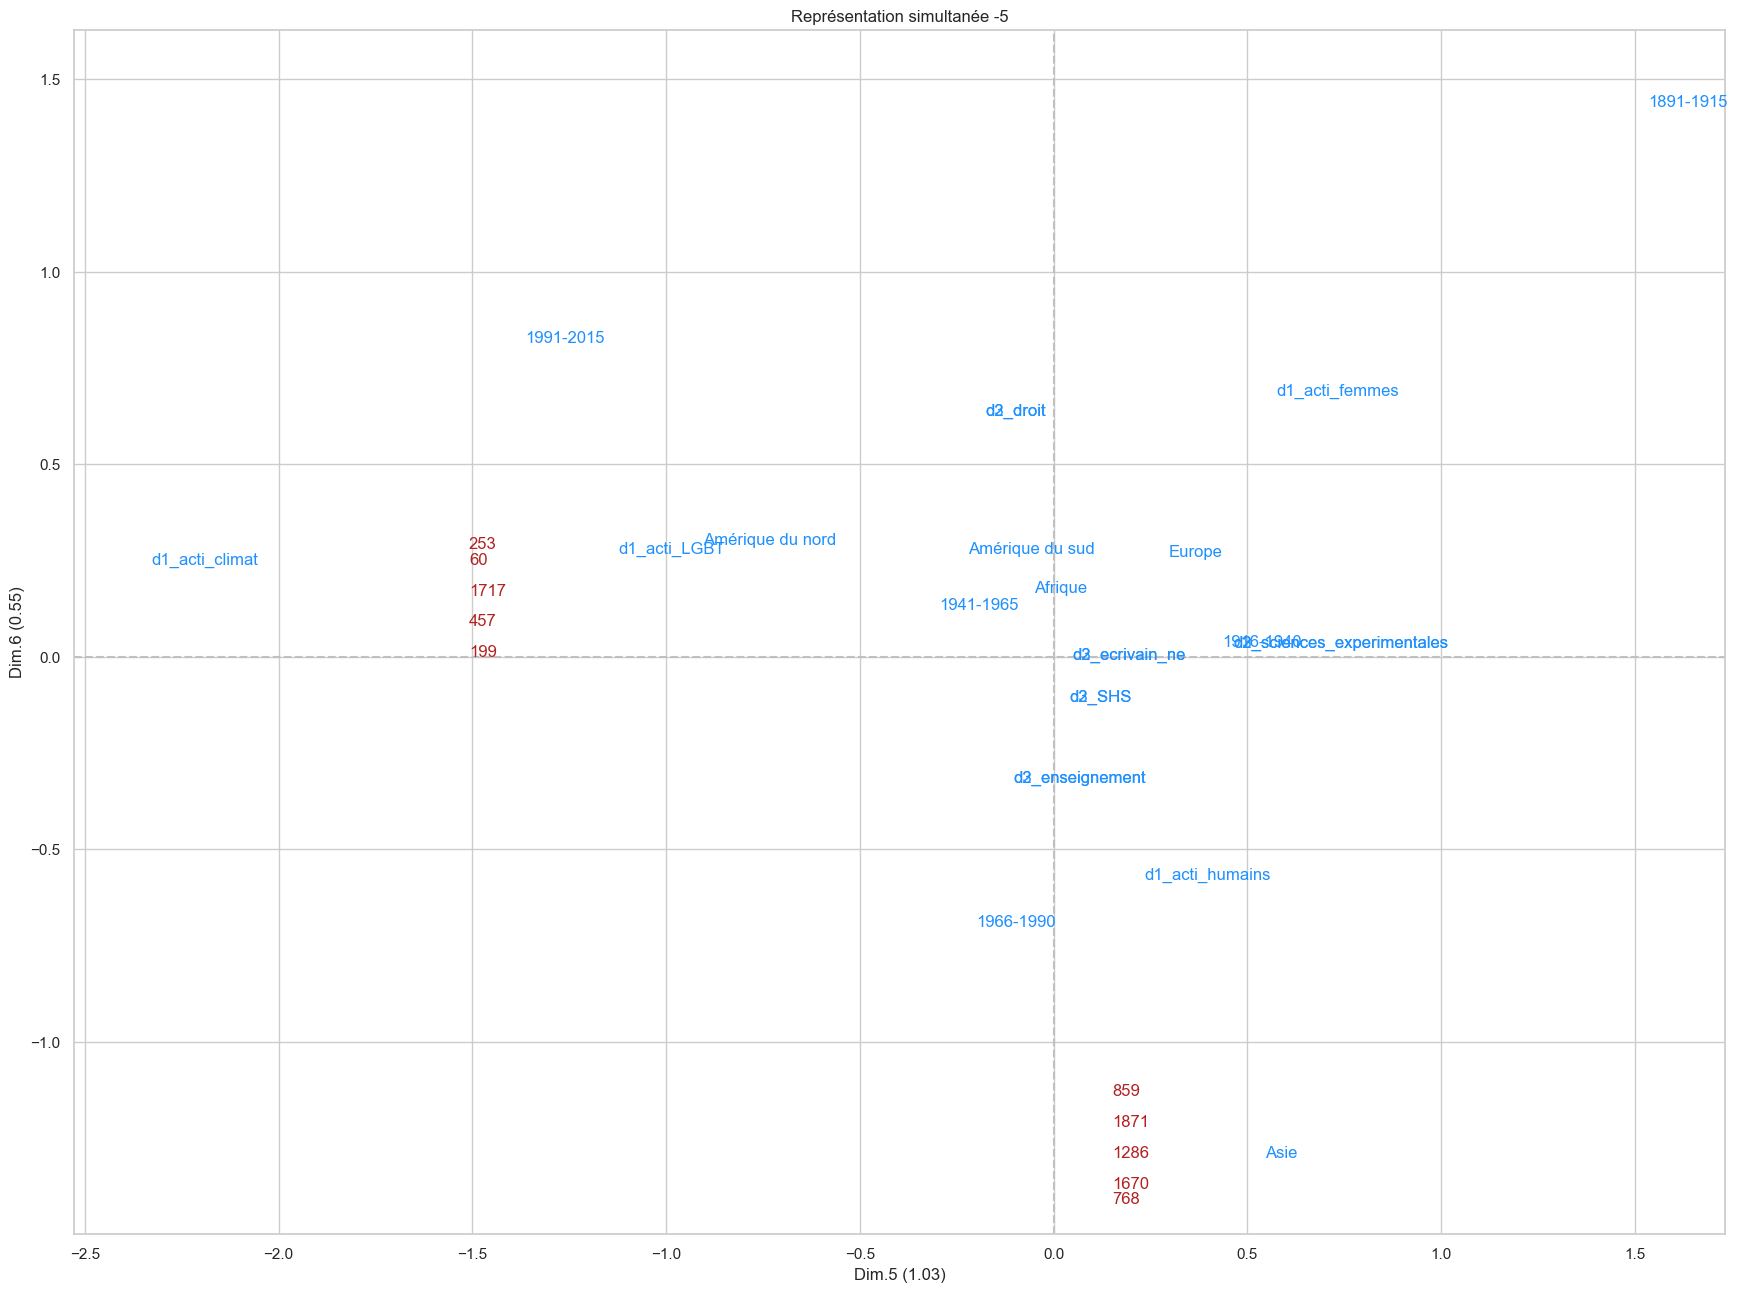

|      | per_25    | origine_geo      | o1              | o2              | o3              |
|-----:|:----------|:-----------------|:----------------|:----------------|:----------------|
|  199 | 1941-1965 | Amérique du nord | d1_acti_climat  | d2_enseignement | d3_enseignement |
|  457 | 1941-1965 | Amérique du nord | d1_acti_climat  | d2_enseignement | d3_enseignement |
| 1717 | 1941-1965 | Amérique du nord | d1_acti_climat  | d2_enseignement | d3_enseignement |
|   60 | 1941-1965 | Amérique du nord | d1_acti_climat  | d2_enseignement | d3_enseignement |
|  253 | 1941-1965 | Amérique du nord | d1_acti_climat  | d2_enseignement | d3_enseignement |
|  768 | 1966-1990 | Asie             | d1_acti_humains | d2_enseignement | d3_enseignement |
| 1670 | 1966-1990 | Asie             | d1_acti_humains | d2_enseignement | d3_enseignement |
| 1286 | 1966-1990 | Asie             | d1_acti_humains | d2_enseignement | d3_enseignement |
| 1871 | 1966-1990 | Asie             | d1_acti_humains | d2

In [126]:
# Mapping des points colonnes

i = 1
dfc = acm.col_topandas()

df_rows = acm.row_topandas()




### avec la correction de Benzecri, 
# 3 axes apportent 95%  de l'information
while i < 6:    

    #c1 = 'col_contrib_dim' + str(i)  
    #c2 = 'col_contrib_dim' + str(1+i)

    c1 = 'col_cos2_dim' + str(i)  
    c2 = 'col_cos2_dim' + str(1+i)


    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    r1 = dfc[c1].sort_values(ascending=True)[:10]
    r1.plot(kind='barh', ax=axes[0], title="Cos-2 de l'axe"+ str(i))

    r2 = dfc[c2].sort_values(ascending=True)[:10]
    r2.plot(kind='barh', ax=axes[1], title="Cos-2 de l'axe"+ str(i+1))

    plt.tight_layout()
    plt.show()


    # rc1 = 'row_contrib_dim' + str(i)  
    # rc2 = 'row_contrib_dim' + str(1+i)
    rc1 = 'row_cos2_dim' + str(i)  
    rc2 = 'row_cos2_dim' + str(1+i)

    ### Filtrer les individus donnant la plus grande contribution à l'axe
    # On retient les individus les mieux représentés sur chaque axe
    rcv1 = df_rows[rc1].sort_values(ascending=False)[:5].index
    rcv2 = df_rows[rc2].sort_values(ascending=False)[:5].index

    lrc = list(set(list(rcv1) + list(rcv2)))


    min_d1 = min(dfc['col_coord_dim' + str(i)])-0.2
    max_d1 = max(dfc['col_coord_dim' + str(i)])+0.2
    min_d2 = min(dfc['col_coord_dim' + str(i+1)])-0.2
    max_d2 = max(dfc['col_coord_dim' + str(i+1)])+0.2

    #représentation simultanée
    #fig,ax = plt.subplots(figsize=(20, 20))
    fig,ax = plt.subplots(figsize=((min_d1*-1 + max_d1)*5, (min_d2*-1 + max_d2)*5))
    ax.axis([min_d1,max_d1,min_d2,max_d2])
    ax.plot([min_d1,max_d1],[0,0],color='silver',linestyle='--')
    ax.plot([0,0],[min_d2,max_d2],color='silver',linestyle='--')

    ax.set_xlabel("Dim."+str(i)+" ("+ str(round(bzc.freq.iloc[(i-1)],2))+")")
    ax.set_ylabel("Dim."+str(i+1)+" ("+ str(round(bzc.freq.iloc[i],2))+")")

    plt.title("Représentation simultanée -" + str(i))
    for i1 in range(df.shape[1]):
        ax.text(acm.col_coord_[i1,(i-1)],acm.col_coord_[i1,i],df.columns[i1],color='dodgerblue')
    
    ### espacer légèrement les individus
    a = -0.08
    for i2 in lrc:
        ax.text(acm.row_coord_[i2,(i-1)],acm.row_coord_[i2,i]+ a,df.index[i2],color='firebrick')        
        a += 0.04
    plt.show()

    print(DActives_ct.iloc[lrc].sort_values(by='per_25').to_markdown())

    i += 2